# Can we reproduce the VIRGO PSD with `celerite` kernels?

First load the VIRGO data, interpolate over missing measurements. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [2]:
hdu = fits.open('data/VIRGO_1min_0083-7404.fits')

In [3]:
hdu[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

Text(0,0.5,'W/m$^2$')

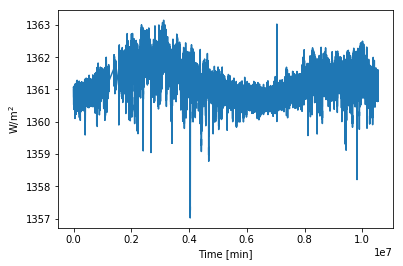

In [4]:
fluxes = hdu[0].data
times = np.arange(len(fluxes))

interp_fluxes = np.interp(times[fluxes == -99], times[fluxes != -99], fluxes[fluxes != -99])
fluxes[fluxes == -99] = interp_fluxes

plt.plot(times, fluxes)
plt.xlabel('Time [min]')
plt.ylabel('W/m$^2$')

Compute the power spectrum: 

In [5]:
from scipy.signal import periodogram
f, Pxx_den = periodogram(fluxes, fs=1/60)#, scaling='spectrum')

Compute the median of the power spectrum: 

In [6]:
from scipy.stats import binned_statistic

bs = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanmedian, bins=500)

# bs_std = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanstd, bins=500)

bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Narrow our focus to frequencies less than 5000 Hz: 

In [7]:
cutoff_freq = 5000
y = bs.statistic[1e6 * np.exp(bincenters) < cutoff_freq]
x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < cutoff_freq]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

Let's fit the power spectrum at low frequencies as the sum of $N=3$ components: 

$$  P(\nu) = \sum_{i=1}^{N} P_i = \sum_{i=1}^{N} \frac{A_i}{1 + (B_i\nu)^{C_i}} $$

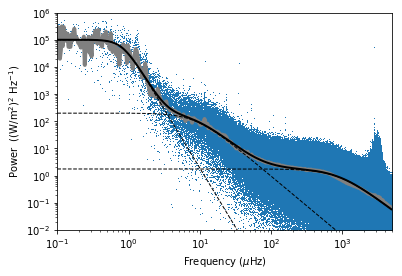

In [8]:
def individual_model(p, nu=x):
    a, b, c = p
    s = a / (1 + (b * nu)**c)
    return s

def low_freq_model(p, nu=x):
    s = np.zeros_like(nu)
    for a, b, c in np.array(p).reshape((len(p)//3, 3)):
        s += a / (1 + (b * nu)**c)
    return s

def minimize(p):
    """Optimize least squares in log space"""
    return np.sum( (np.log10(y) - np.log10(low_freq_model(p)))**2 )

from scipy.optimize import fmin_l_bfgs_b

initp = [1e5, 1.5, 4, 
         200, 0.08, 3, 
         2, 0, 3]
bounds = [[0.5e5, 3e5], [0.3, 2], [2, 5], 
          [100, 300], [0, 1], [2, 5], 
          [0, 5], [-1, 1], [2, 5]]

fig, ax = plt.subplots()
bestp_lowfreq = fmin_l_bfgs_b(minimize, initp, bounds=bounds, approx_grad=True)[0]
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.loglog(x, y, color='gray', lw=4, label='Binned')
# plt.loglog(1e6 * x, model(initp))
ax.loglog(x, low_freq_model(bestp_lowfreq), color='k', lw=2, label='Fit')
ax.loglog(x, individual_model(bestp_lowfreq[:3]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp_lowfreq[3:6]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp_lowfreq[6:9]), color='k', lw=1, ls='--')

ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

ax.set_xlim([1e-1, cutoff_freq])
ax.set_ylim([1e-2, 1e6])
plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

The above figure is a reproduction of Aigrain et al. 2003 Figure 2a. 

***

# Using `celerite`

Now let's fit the power spectrum again, this time using `celerite`

In [9]:
from scipy.ndimage import gaussian_filter1d

smoothed_spectrum = gaussian_filter1d(Pxx_den, 50)

Use a list of preliminary $p$-mode frequencies from Frolich et al. 1997 Table 2: 

In [21]:
len(table2)

96

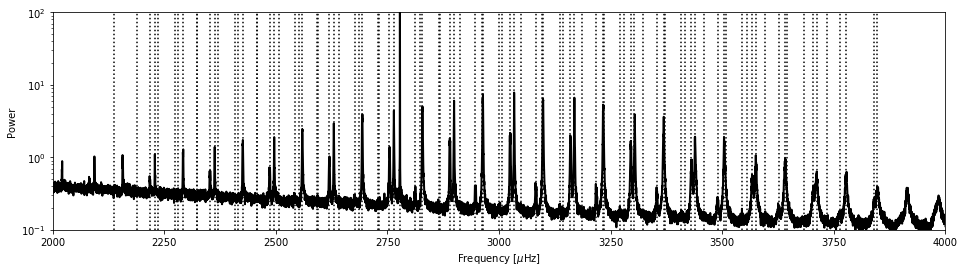

In [10]:

fig, ax = plt.subplots(figsize=(16, 4))
#ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')
ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
       xlim=[2000, 4000], ylim=[1e-1, 1e2])

table2 = [2137.79, 2217.63, 2273.47,
2228.34, 2292.17, 2352.29, 2407.73,
2362.96, 2425.68, 2486.05, 2541.70,
2496.14, 2559.29, 2619.69, 2676.23,
2630.03, 2693.32, 2754.44, 2811.49,
2764.43, 2828.19, 2889.59, 2946.97,
2898.95, 2963.32, 3024.75, 3082.31,
3033.75, 3098.16, 3159.83, 3217.74,
3168.67, 3233.21, 3295.25, 3353.58,
3303.21, 3368.64, 3430.76, 3489.65,
3438.95, 3504.39, 3567.02, 3626.35,
3574.62, 3640.35, 3703.41, 3763.01,
3711.45, 3777.07, 3840.84, 3847.28,
2188.43, 2235.42, 2280.08, 2322.40, 
2324.31, 2371.23, 2415.59, 2458.25, 
2458.53, 2506.00, 2551.12, 2594.27, 
2593.16, 2641.25, 2687.08, 2731.08, 
2728.51, 2777.24, 2823.81, 2868.40, 
2864.28, 2913.51, 2960.62, 3005.54, 
3000.13, 3049.84, 3097.09, 3142.77, 
3135.96, 3186.26, 3234.17, 3279.76, 
3271.74, 3322.67, 3370.91, 3417.35, 
3408.14, 3459.74, 3508.80, 3554.93, 
3544.67, 3596.35, 3646.05, 3682.25, 3734.72]

for line in table2: 
    ax.axvline(line, ls=':', color='k')


In [11]:
import celerite
from celerite import terms

In [12]:
from scipy.optimize import fmin_powell, fmin_l_bfgs_b

Fit each power spectrum peak near the $p$-modes from Frohlich et al. 1997:  

Optimization terminated successfully.
         Current function value: 824.025524
         Iterations: 2
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 916.408675
         Iterations: 3
         Function evaluations: 179


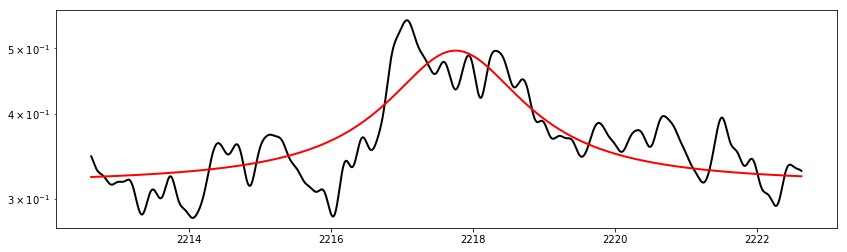

Optimization terminated successfully.
         Current function value: 592.476931
         Iterations: 2
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 1273.829121
         Iterations: 5
         Function evaluations: 296


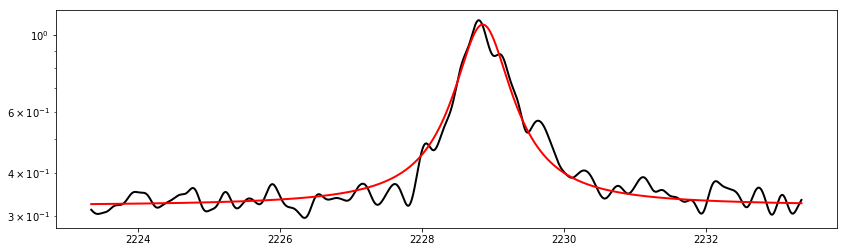

Optimization terminated successfully.
         Current function value: 1877.494085
         Iterations: 6
         Function evaluations: 345


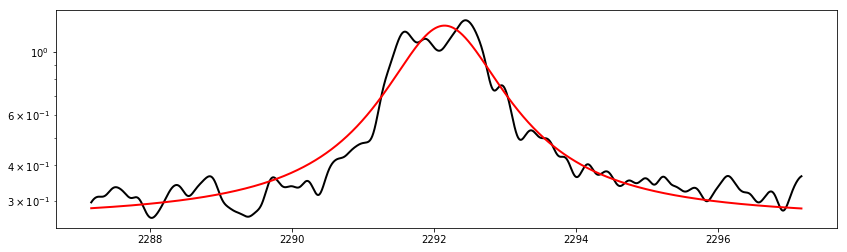

Optimization terminated successfully.
         Current function value: 986.985631
         Iterations: 6
         Function evaluations: 360


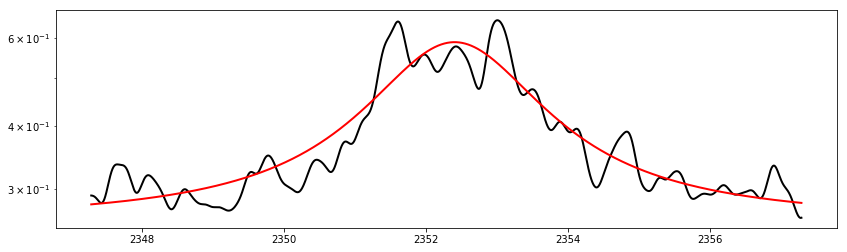

Optimization terminated successfully.
         Current function value: 471.107841
         Iterations: 2
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 1504.801726
         Iterations: 6
         Function evaluations: 362


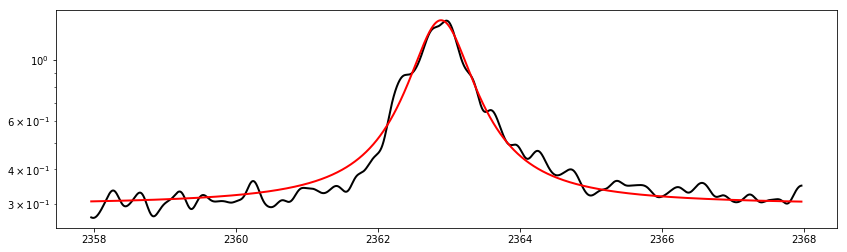

Optimization terminated successfully.
         Current function value: 3526.473902
         Iterations: 7
         Function evaluations: 415


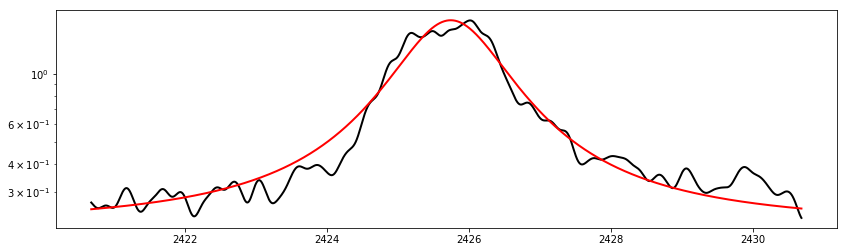

Optimization terminated successfully.
         Current function value: 1223.497926
         Iterations: 6
         Function evaluations: 360


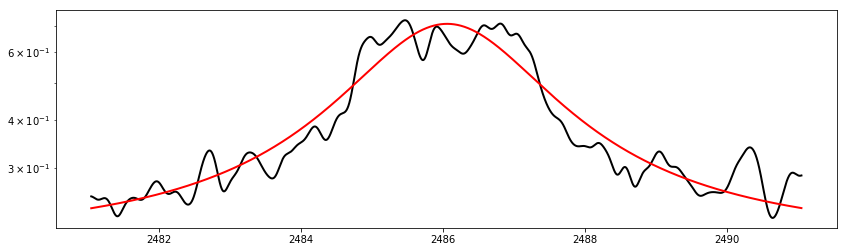

Optimization terminated successfully.
         Current function value: 417.893606
         Iterations: 2
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 2621.164310
         Iterations: 6
         Function evaluations: 357


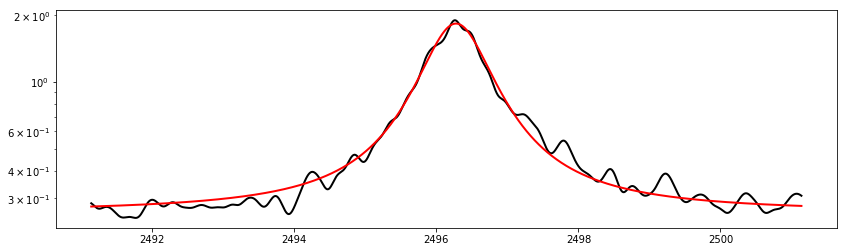

Optimization terminated successfully.
         Current function value: 5784.890542
         Iterations: 11
         Function evaluations: 658


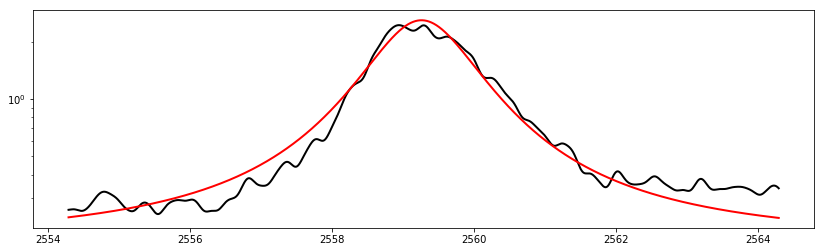

Optimization terminated successfully.
         Current function value: 1728.628197
         Iterations: 6
         Function evaluations: 360


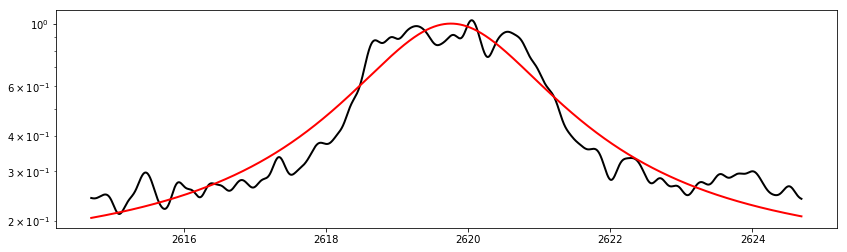

Optimization terminated successfully.
         Current function value: 399.103780
         Iterations: 2
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 5419.404942
         Iterations: 12
         Function evaluations: 720


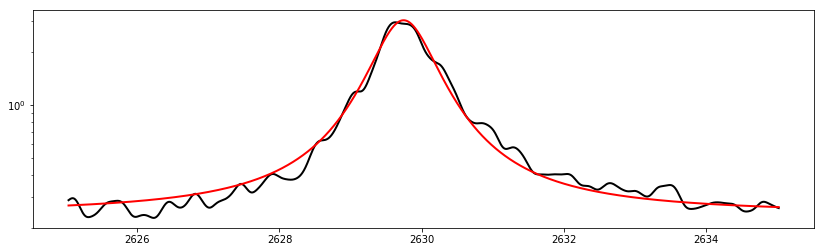

Optimization terminated successfully.
         Current function value: 12110.880983
         Iterations: 12
         Function evaluations: 729


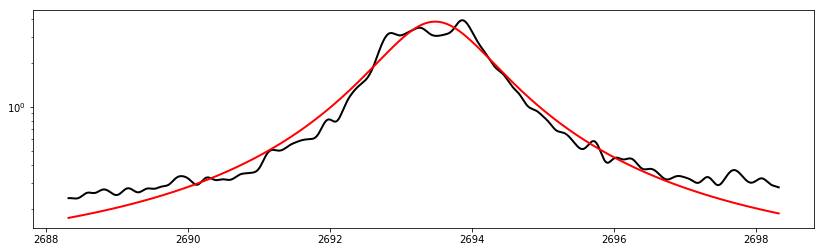

Optimization terminated successfully.
         Current function value: 3091.232254
         Iterations: 4
         Function evaluations: 242


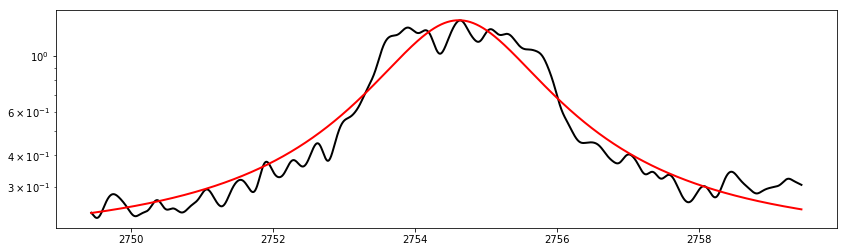

Optimization terminated successfully.
         Current function value: 453.613782
         Iterations: 2
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 10995.962591
         Iterations: 7
         Function evaluations: 428


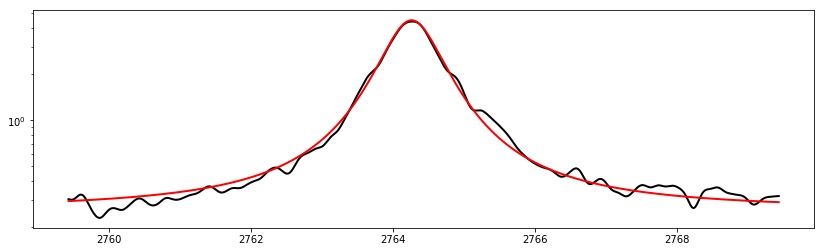

Optimization terminated successfully.
         Current function value: 22289.423963
         Iterations: 16
         Function evaluations: 965


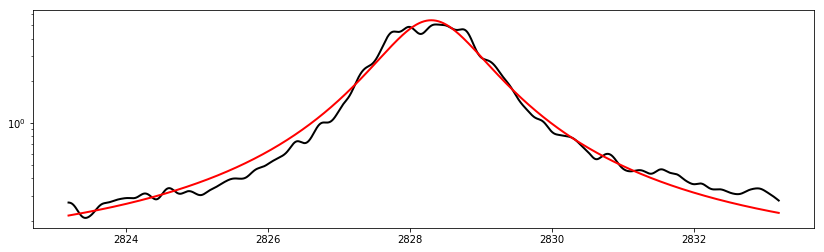

Optimization terminated successfully.
         Current function value: 4670.071452
         Iterations: 6
         Function evaluations: 369


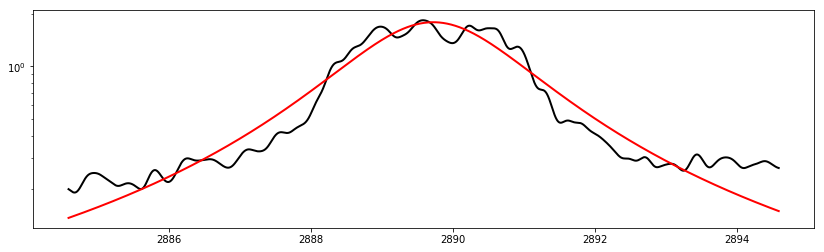

Optimization terminated successfully.
         Current function value: 451.465755
         Iterations: 8
         Function evaluations: 497


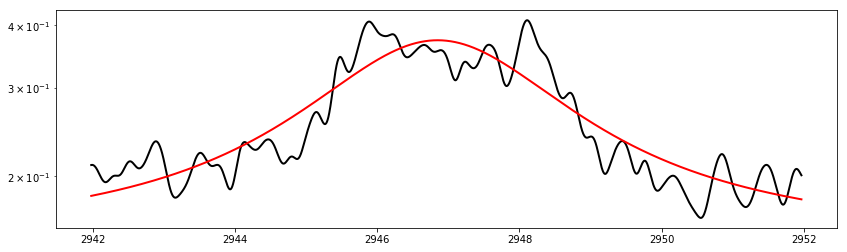

Optimization terminated successfully.
         Current function value: 20891.355713
         Iterations: 28
         Function evaluations: 1709


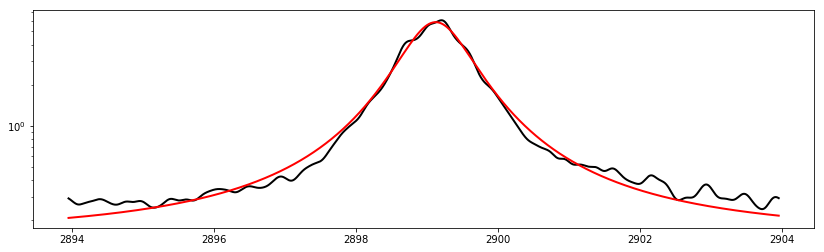

Optimization terminated successfully.
         Current function value: 40323.729690
         Iterations: 17
         Function evaluations: 1040


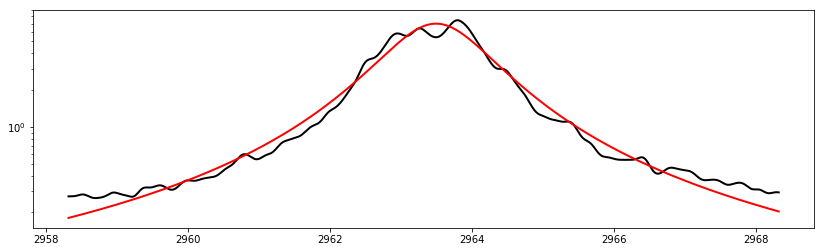

Optimization terminated successfully.
         Current function value: 6429.015322
         Iterations: 3
         Function evaluations: 181


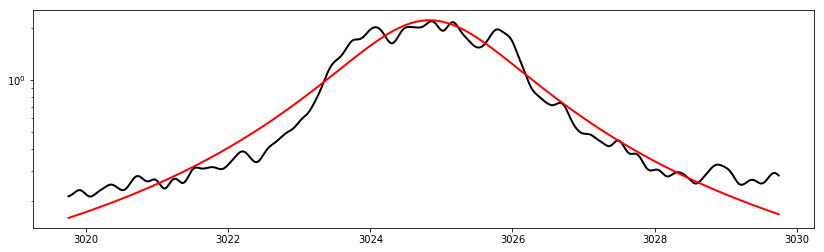

Optimization terminated successfully.
         Current function value: 496.435564
         Iterations: 8
         Function evaluations: 493


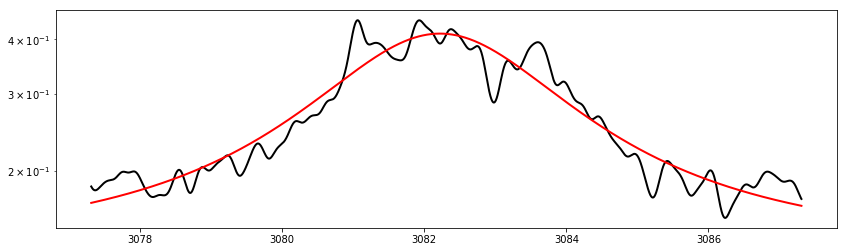

Optimization terminated successfully.
         Current function value: 28041.302796
         Iterations: 9
         Function evaluations: 535


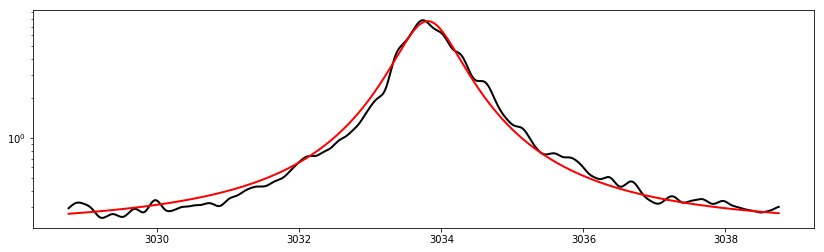

Optimization terminated successfully.
         Current function value: 42827.917040
         Iterations: 17
         Function evaluations: 1010


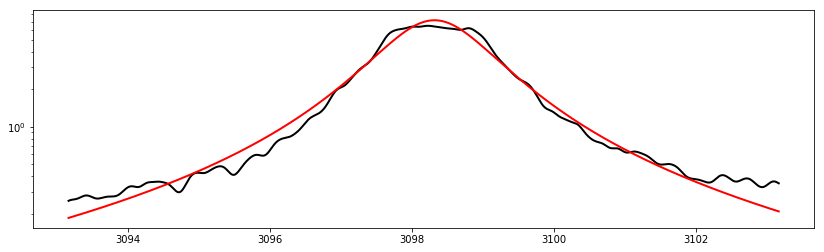

Optimization terminated successfully.
         Current function value: 5806.416360
         Iterations: 4
         Function evaluations: 238


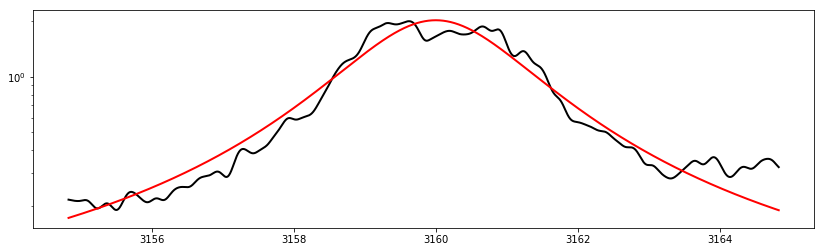

Optimization terminated successfully.
         Current function value: 445.172016
         Iterations: 8
         Function evaluations: 492


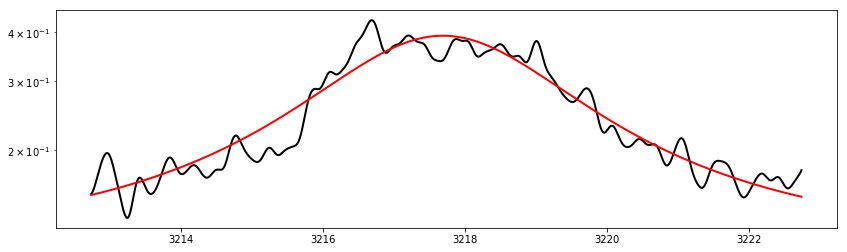

Optimization terminated successfully.
         Current function value: 24360.453372
         Iterations: 9
         Function evaluations: 535


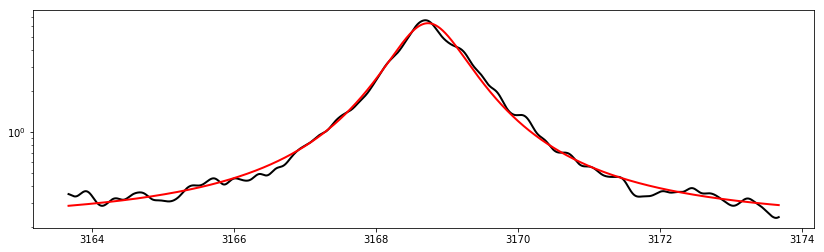

Optimization terminated successfully.
         Current function value: 28581.451031
         Iterations: 17
         Function evaluations: 1020


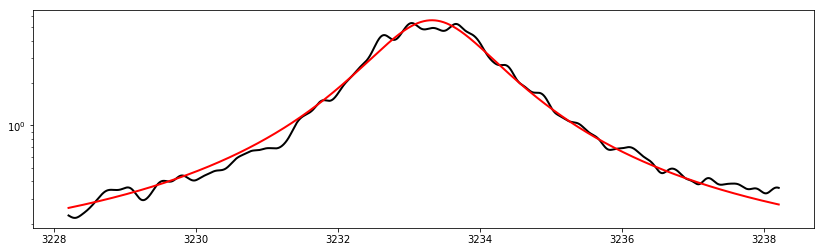

Optimization terminated successfully.
         Current function value: 4208.847608
         Iterations: 4
         Function evaluations: 239


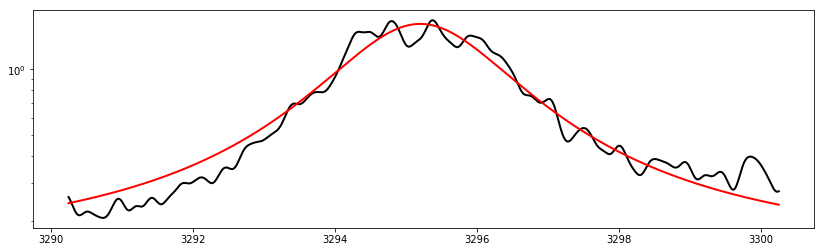

Optimization terminated successfully.
         Current function value: 361.636573
         Iterations: 2
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 12552.085165
         Iterations: 20
         Function evaluations: 1206


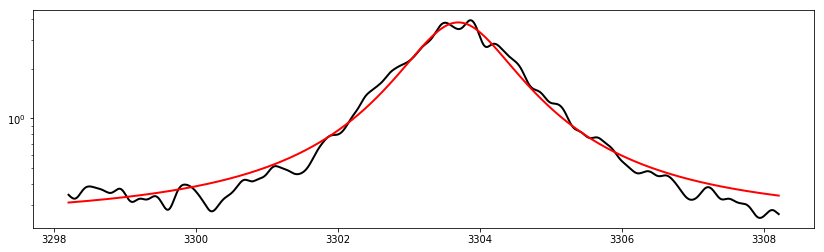

Optimization terminated successfully.
         Current function value: 13494.524193
         Iterations: 6
         Function evaluations: 380


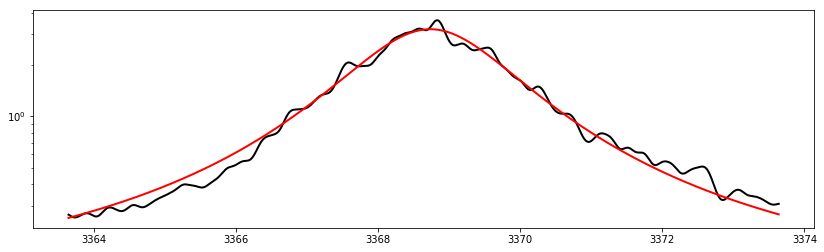

Optimization terminated successfully.
         Current function value: 1750.469526
         Iterations: 4
         Function evaluations: 247


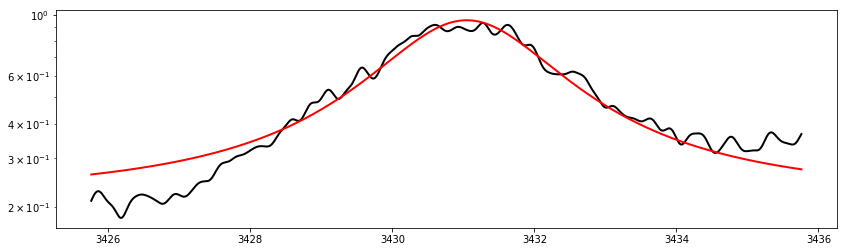

Optimization terminated successfully.
         Current function value: 271.493181
         Iterations: 2
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 4817.933620
         Iterations: 4
         Function evaluations: 235


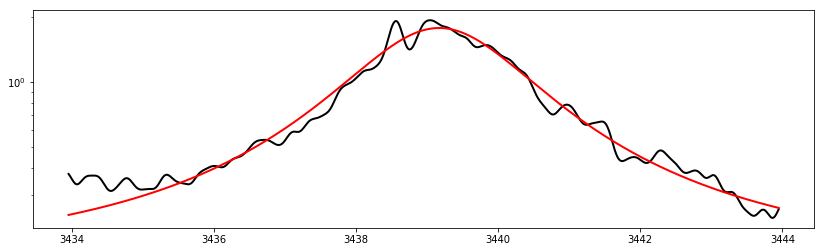

Optimization terminated successfully.
         Current function value: 5687.998264
         Iterations: 4
         Function evaluations: 251


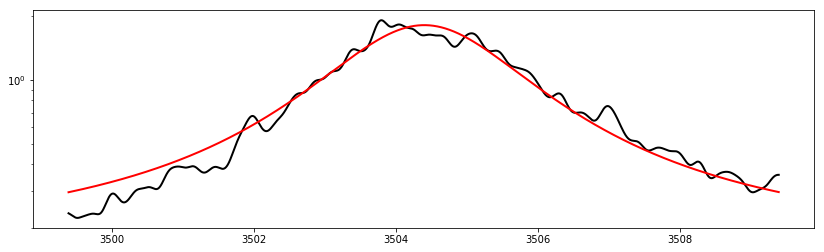

Optimization terminated successfully.
         Current function value: 893.630306
         Iterations: 4
         Function evaluations: 256


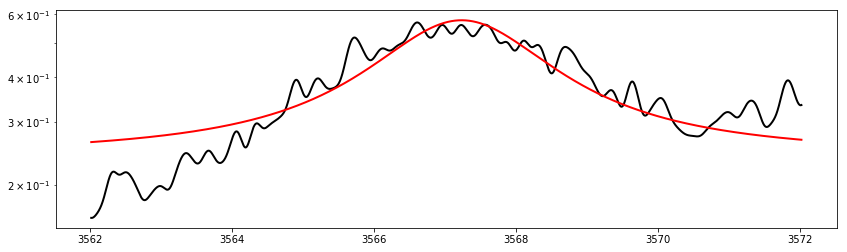

Optimization terminated successfully.
         Current function value: 197.757680
         Iterations: 2
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: 2133.225684
         Iterations: 4
         Function evaluations: 248


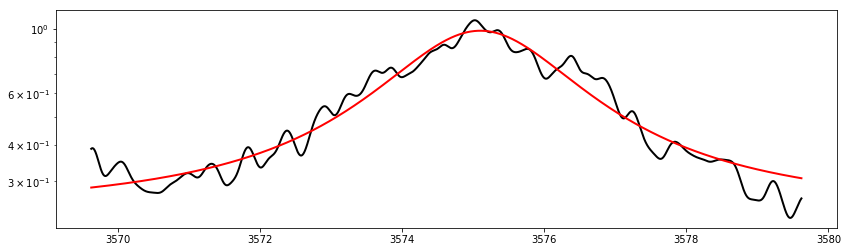

Optimization terminated successfully.
         Current function value: 2019.148532
         Iterations: 8
         Function evaluations: 468


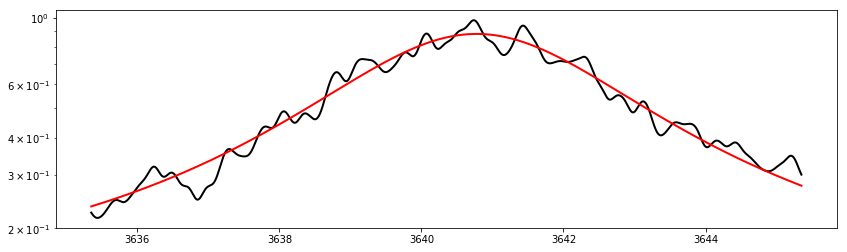

Optimization terminated successfully.
         Current function value: 550.947046
         Iterations: 4
         Function evaluations: 254


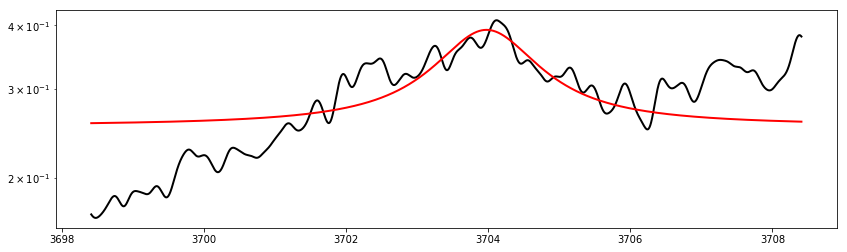

Optimization terminated successfully.
         Current function value: 151.528222
         Iterations: 2
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 1041.776760
         Iterations: 4
         Function evaluations: 248


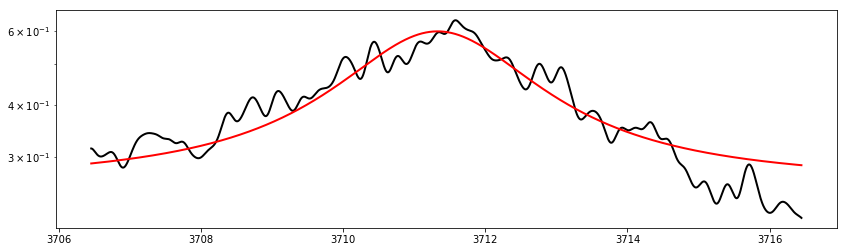

Optimization terminated successfully.
         Current function value: 940.834255
         Iterations: 8
         Function evaluations: 476


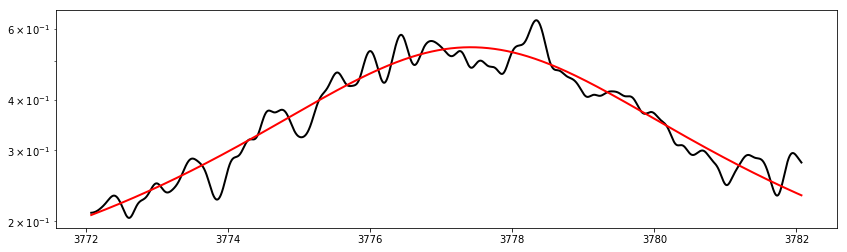

Optimization terminated successfully.
         Current function value: 349.739657
         Iterations: 2
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 551.043214
         Iterations: 8
         Function evaluations: 498


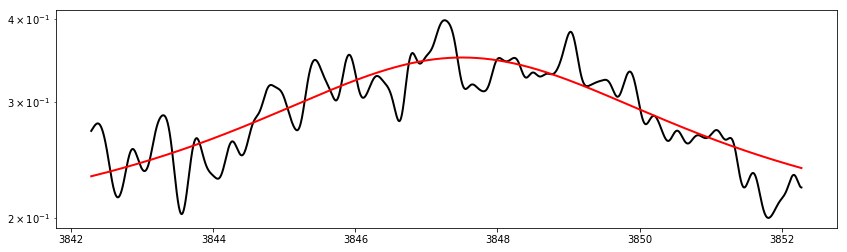

Optimization terminated successfully.
         Current function value: 717.619461
         Iterations: 2
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 693.830793
         Iterations: 3
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 617.394917
         Iterations: 2
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 537.849801
         Iterations: 2
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 531.701784
         Iterations: 2
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: 583.807902
         Iterations: 2
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 468.655258
         Iterations: 2
         Function evaluations: 141
Optimization termina

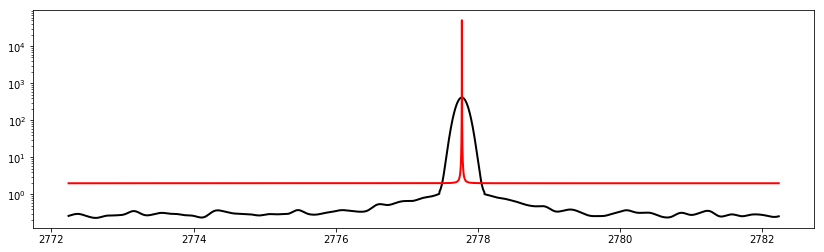

Optimization terminated successfully.
         Current function value: 18402.432479
         Iterations: 7
         Function evaluations: 392


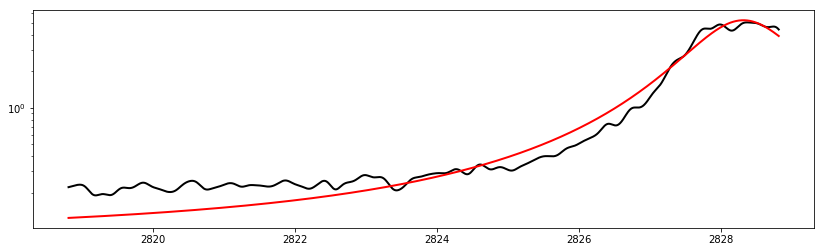

Optimization terminated successfully.
         Current function value: 260.127238
         Iterations: 2
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 257.416799
         Iterations: 2
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 268.791024
         Iterations: 2
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 39998.235100
         Iterations: 6
         Function evaluations: 383


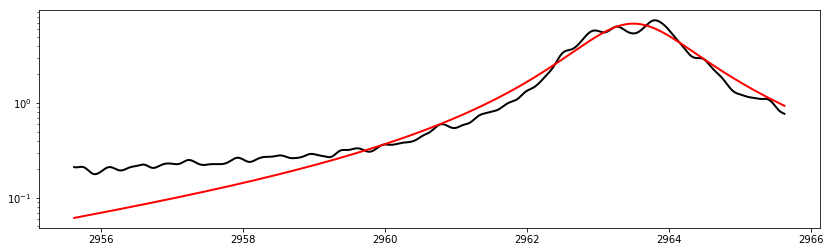

Optimization terminated successfully.
         Current function value: 222.124471
         Iterations: 2
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 244.109613
         Iterations: 2
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 234.283935
         Iterations: 2
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 42733.405392
         Iterations: 9
         Function evaluations: 518


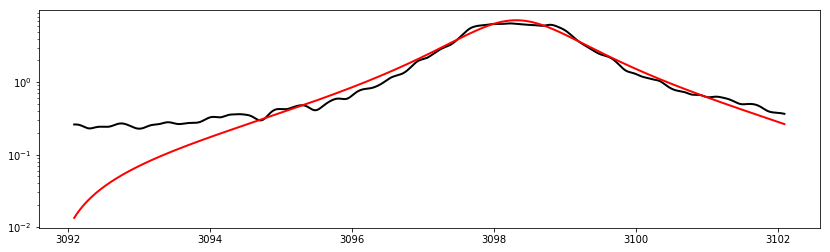

Optimization terminated successfully.
         Current function value: 178.424043
         Iterations: 2
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 202.881075
         Iterations: 2
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 200.682843
         Iterations: 2
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 28579.212883
         Iterations: 12
         Function evaluations: 703


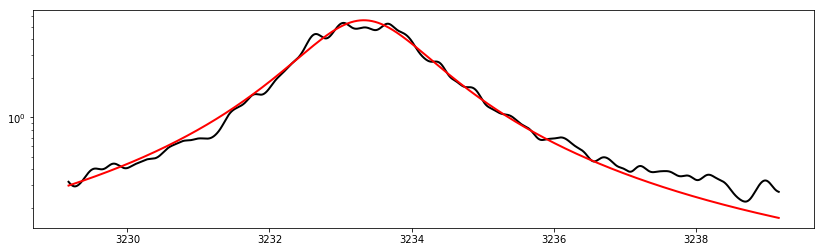

Optimization terminated successfully.
         Current function value: 169.052677
         Iterations: 2
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 180.693320
         Iterations: 2
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 166.540223
         Iterations: 2
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 13438.327870
         Iterations: 5
         Function evaluations: 293


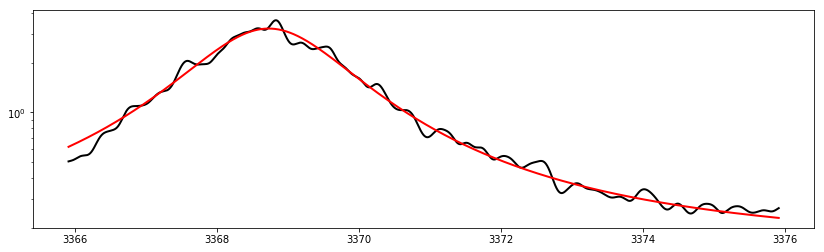

Optimization terminated successfully.
         Current function value: 134.877527
         Iterations: 2
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 150.922074
         Iterations: 2
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 148.558702
         Iterations: 2
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 4124.952258
         Iterations: 10
         Function evaluations: 526


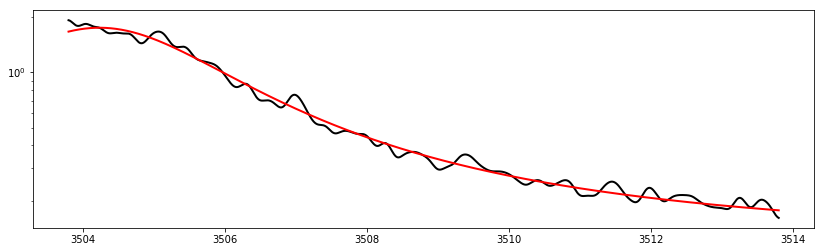

Optimization terminated successfully.
         Current function value: 129.272478
         Iterations: 2
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 127.573009
         Iterations: 2
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 125.311585
         Iterations: 2
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 1032.108674
         Iterations: 13
         Function evaluations: 696


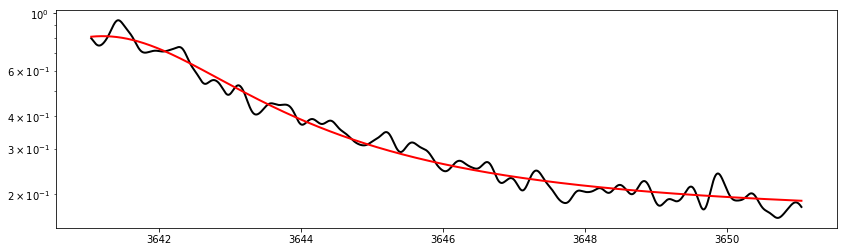

Optimization terminated successfully.
         Current function value: 109.303010
         Iterations: 2
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 101.224768
         Iterations: 2
         Function evaluations: 140


In [13]:
parameters = []

log_omegas = np.log(2 * np.pi * (1e-6 * np.array(table2)))

for i, peak in enumerate(table2):    
    
    fit_bounds = ((1e6 * f < peak + 5) & (1e6 * f > peak - 5))
    
    def model(p):
        kernel = terms.SHOTerm(log_S0=p[0], log_omega0=p[1], log_Q=p[2])

        #gp = celerite.GP(kernel)
        psd = kernel.get_psd(2 * np.pi * f[fit_bounds])
        return psd + p[3]

    def minimize(p):
        return np.nansum((model(p) - Pxx_den[fit_bounds])**2)
    
    omega_bounds = np.log([2*np.pi*f[fit_bounds].min(), 2*np.pi*f[fit_bounds].max()])
    bounds = [[-20, -10], [omega_bounds[0], omega_bounds[1]], [5, 10], [0, 1]]
    #bestp = fmin_l_bfgs_b(minimize, [-13, log_omegas[i], 7, 0.3], bounds=bounds, approx_grad=True)[0]
    bestp = fmin_powell(minimize, [-13, log_omegas[i], 7, 0.3])
    
    best_model = model(bestp)
    if best_model.ptp() > 0.1: 
        parameters.append(bestp)

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.semilogy(1e6 * f[fit_bounds], smoothed_spectrum[fit_bounds], lw=2, color='k')
        ax.semilogy(1e6 * f[fit_bounds], best_model, lw=2, color='r')
        plt.show()
        
        
parameters = np.array(parameters)

Plot the sum of all of the best-fit kernel PSDs: 

(0.01, 100.0)

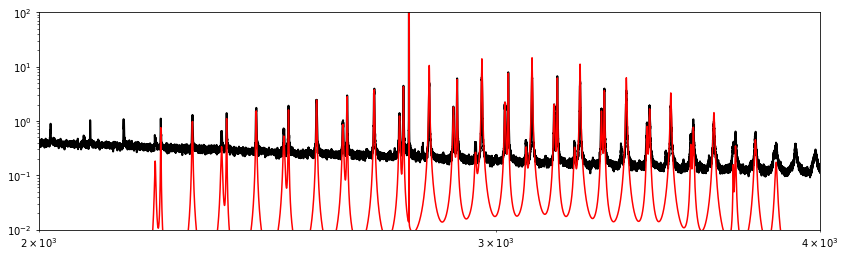

In [14]:
def megamodel(p):
    kernel = None
    p_reshaped = np.array(p).reshape(len(p)//3, 3)
    for i, p0_p2 in enumerate(p_reshaped):
        p0, p1, p2 = p0_p2
        if kernel is None:
            kernel = terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
        else: 
            kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
    psd = kernel.get_psd(2*np.pi*f)
    return psd 

megamodel_bestp = megamodel(parameters[:, :3].ravel())

fig, ax = plt.subplots(figsize=(14, 4))
ax.loglog(1e6 * f, smoothed_spectrum, lw=2, color='k')
ax.loglog(1e6 * f, megamodel_bestp, color='r')
ax.set_xlim([2000, 4000])
ax.set_ylim([1e-2, 1e2])

Fit for two components (rather than 3 as in Aigrain et al.) to describe the low frequency oscillations: 

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Optimization terminated successfully.
         Current function value: 76.173065
         Iterations: 6
         Function evaluations: 522


Text(0,0.5,'Power ((W/m$^2$)$^2$ Hz$^{-1}$)')

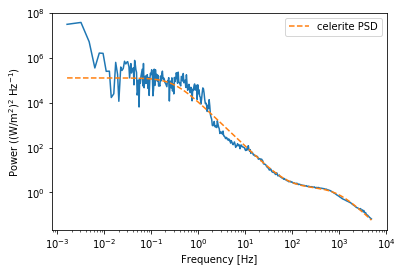

In [15]:
kernel = (terms.SHOTerm(log_S0=10, log_omega0=-5, log_Q=1) +
          terms.SHOTerm(log_S0=10, log_omega0=-5, log_Q=1))

from scipy.optimize import fmin_powell, fmin_l_bfgs_b

def minimize(p):
    kernel.set_parameter_vector(p)
    return np.sum( ( np.log(low_freq_model(bestp_lowfreq)) - np.log(kernel.get_psd(2 * np.pi * x * 1e-6)) )**2 ) 

initp = [11.96511414, -8.55718427,  9.19830828,  
         0.72794889, -1.50612712, 10.13790919]
fit1 = fmin_powell(minimize, initp)

kernel.set_parameter_vector(fit1)

fig, ax = plt.subplots()
ax.loglog(x, y)
ax.loglog(x, kernel.get_psd(2 * np.pi * x * 1e-6), ls='--', label='celerite PSD')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power ((W/m$^2$)$^2$ Hz$^{-1}$)')

Sum all of the kernels (low + high freq.) together to replicate the full power spectrum: 

In [16]:
kernel = (terms.SHOTerm(log_S0=fit1[0], log_omega0=fit1[1], log_Q=fit1[2]) + 
          terms.SHOTerm(log_S0=fit1[3], log_omega0=fit1[4], log_Q=fit1[5]))
kernel.set_parameter_vector(fit1)

for i, p0_p2 in enumerate(parameters[:, :3]):
    p0, p1, p2 = p0_p2
    kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)

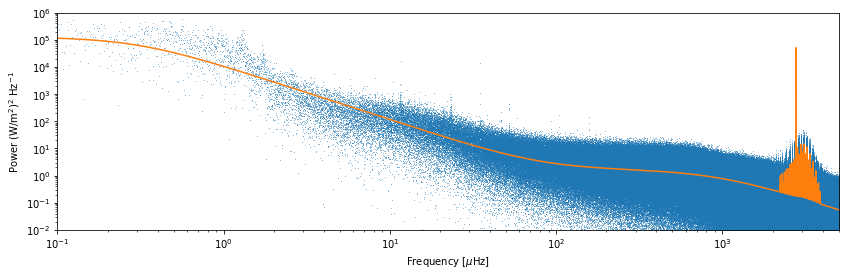

In [17]:
# psd = kernel.get_psd(2 * np.pi * f)
fig, ax = plt.subplots(figsize=(14, 4))
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, alpha=0.5)
ax.loglog(1e6 * f, kernel.get_psd(2*np.pi*f))
# ax.loglog(1e6 * f, psd)
ax.set_xlim([1e-1, 5000])
ax.set_ylim([1e-2, 1e6])
ax.set(xlabel="Frequency [$\mu$Hz]", ylabel='Power (W/m$^2$)$^2$ Hz$^{-1}$')
fig.savefig('paper_plots/psd.pdf', bbox_inches='tight')

Zoom into the $p$-mode oscillations: 

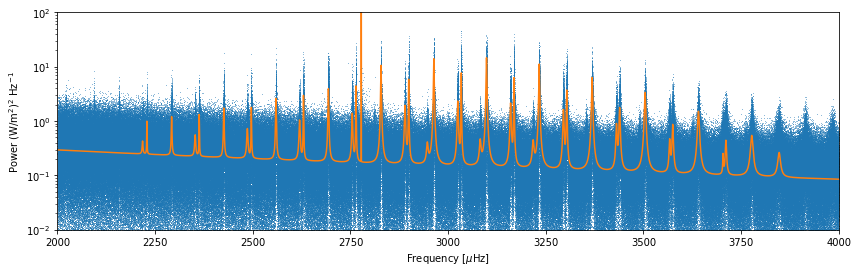

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, alpha=0.5)
ax.semilogy(1e6 * f, kernel.get_psd(2*np.pi*f))
# ax.loglog(1e6 * f, psd)
ax.set_xlim([2000, 4000])
ax.set_ylim([1e-2, 1e2])
ax.set(xlabel="Frequency [$\mu$Hz]", ylabel='Power (W/m$^2$)$^2$ Hz$^{-1}$')
fig.savefig('paper_plots/psd_zoom.pdf', bbox_inches='tight')

Draw samples from the kernel which reproduces the PSD: 

In [19]:
gp = celerite.GP(kernel)
fs = 1/60/60/24 # # Sampling cadence = 25 s
xtest = np.arange(0, 10, fs)
gp.compute(xtest)
ytest = gp.sample()

Plot the draws from the kernel: 

[]

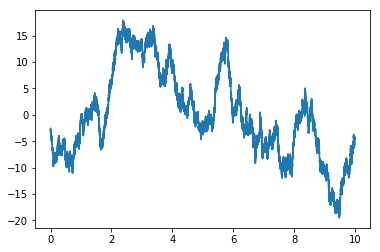

In [22]:
sample_ppm = 1e6 * ytest/fluxes.mean()
sample_ppm -= sample_ppm.mean()
plt.plot(xtest, sample_ppm)

In [67]:
ftest, Ptest = periodogram(ytest, fs=1/60/60/24)
bs_test = binned_statistic(np.log(ftest[1:]), Ptest[1:], statistic=np.nanmedian, bins=500)
bincenters2 = 0.5 * (bs_test.bin_edges[1:] + bs_test.bin_edges[:-1])
cutoff_freq = 5000
ytest2 = bs_test.statistic[1e6 * np.exp(bincenters2) < cutoff_freq]
xtest2 = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters2) < cutoff_freq]

xtest2 = xtest2[~np.isnan(ytest2)]
ytest2 = ytest2[~np.isnan(ytest2)]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-07, 100000.0)

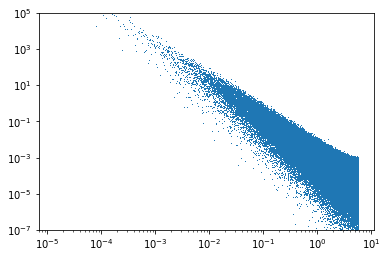

In [68]:
plt.loglog(ftest * 1e6, Ptest, ',', rasterized=True)
# plt.loglog(xtest2, ytest2, color='gray', lw=4, label='Binned')
# plt.xlim([1e-3, cutoff_freq])#  [2000, 4000]) #
plt.ylim([1e-7, 1e5])